In [1]:
using NPZ
using Plots
using FFTW
using Optim
using Statistics
using Distributed
using OffsetArrays
using SparseArrays
using StaticArrays
using SharedArrays
using LinearAlgebra
using BenchmarkTools
using DelimitedFiles

# include custom code
include("./Test/runtests.jl")
include("./Source/ActivePolymer.jl")
using .ActivePolymer
using .ActivePolymer.CorrelationMatrices

Test Summary:                             | Pass  Total  Time
Validation of transforms.                 |    7      7  5.6s
  Forward transforms vs analytic results. |    3      3  2.1s
  Inverse transforms vs input values.     |    4      4  3.5s


# Notebook description

The purpose of this notebook is to test different models for the mechanical properties of the chain, and to find out which model fits the nonlinear simulations best.

# Load data

In [2]:
R, ΔR = ActivePolymer.Optimization.Interface.load_data("Deq1");

# Try out discrete model first, where the Jacobian scales as [2sin(q/2)]^2

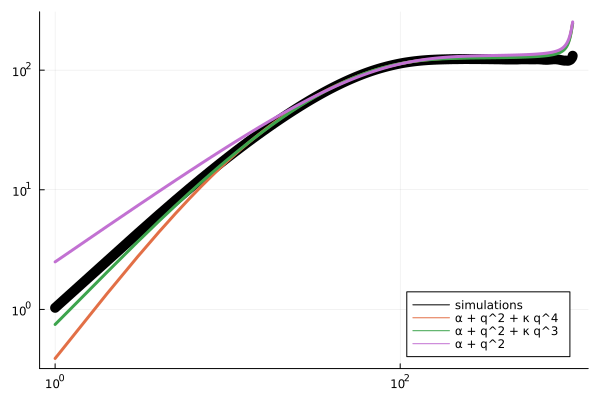

In [3]:
jacmodule=ActivePolymer.Jacobian.Discrete

# Three-parameter fits
opt_numeric_bend = ActivePolymer.Optimization.Interface.fit_mechanics(
    ΔR, modeltype=ActivePolymer.Optimization.Model.Full, jacmodule=jacmodule, n=4, padding=0.85)
opt_numeric_mod  = ActivePolymer.Optimization.Interface.fit_mechanics(
    ΔR, modeltype=ActivePolymer.Optimization.Model.Full, jacmodule=jacmodule, n=3, padding=0.85)

# Two-parameter fits
opt_numeric_red  = ActivePolymer.Optimization.Interface.fit_mechanics(
    ΔR, modeltype=ActivePolymer.Optimization.Model.Reduced, jacmodule=jacmodule, padding=0.85)

# Plot fits
N = size(ΔR,1)

plot(ActivePolymer.Methods.Real.marginalize_translation(ΔR)[2:end], 
    lw=10, xaxis=:log10, yaxis=:log10, legend=:bottomright, label="simulations", lc=:black)
plot!(ActivePolymer.Optimization.Model.numeric_marginalized(N, opt_numeric_bend.minimizer..., n=4, jacmodule=jacmodule)[2:end], 
    lw=3, label="α + q^2 + κ q^4")
plot!(ActivePolymer.Optimization.Model.numeric_marginalized(N, opt_numeric_mod.minimizer..., n=3, jacmodule=jacmodule)[2:end], 
    lw=3, label="α + q^2 + κ q^3")
plot!(ActivePolymer.Optimization.Model.numeric_marginalized(N, opt_numeric_red.minimizer..., jacmodule=jacmodule)[2:end], 
    lw=3, label= "α + q^2")

# Plot direct inversion for bending model

In [4]:
options = opt_numeric_bend
jacobian = jacmodule.J(options.minimizer[2:end]...)

C_inverted = ActivePolymer.Transform.Backward.extract_excitations(R, ΔR, J=jacobian);
plot1 = plot(C_inverted |> diag, title="smoothed diagonal activity profile", titlefontsize=10)
plot!(C_inverted |> diag |> x->imfilter(x, Kernel.gaussian((1,))), title="smoothed diagonal activity profile", titlefontsize=10, lw=5)

plot2 = heatmap(C_inverted, aspect_ratio=:equal, title="raw extracted correlation matrix", titlefontsize=10)

plot3 = heatmap(C_inverted - diagm(C_inverted |> diag) |> x->imfilter(x, Kernel.gaussian((1,1,))), aspect_ratio=:equal, title="smoothed off-diagonal correlation matrix", titlefontsize=10)

C_inverted_rescaled = C_inverted |> diag |> x->x*options.minimizer[begin]/mean(x) |> diagm;
test = ActivePolymer.Transform.Forward.compute_conformation(C_inverted_rescaled, J=jacobian);
ActivePolymer.Methods.Real.correlation_to_separation(test) - ΔR |> x->x.^2 |> mean |> sqrt |> print
plot4 = heatmap(test |> ActivePolymer.Methods.Real.correlation_to_separation, aspect_ratio=:equal,  title="reconstructed separation", titlefontsize=10)

plot5 = heatmap(ΔR, aspect_ratio=:equal,  title="original data", titlefontsize=10)

l = @layout [
    b{0.2h}
    grid(2,2)
]
plot(plot1, plot2, plot3, plot4, plot5, layout = l, legend = false, size = (1000, 1000))

LoadError: MethodError: no method matching extract_excitations(::Vector{Float64}, ::Matrix{Float64}, ::typeof(Main.ActivePolymer.Jacobian.Standard.J₀); J=Main.ActivePolymer.Jacobian.Discrete.var"#1#2"{Float64, Float64, Int64}(0.0005248861758057642, 13.074800583145933, 4))
[0mClosest candidates are:
[0m  extract_excitations(::AbstractVector, ::AbstractMatrix, ::Function; fourier_type) at ~/Documents/Project/Active_Polymer_Conformation/Julia/Source/Transform/Backward.jl:14[91m got unsupported keyword argument "J"[39m
[0m  extract_excitations(::AbstractVector, ::AbstractMatrix) at ~/Documents/Project/Active_Polymer_Conformation/Julia/Source/Transform/Backward.jl:14[91m got unsupported keyword argument "J"[39m

# Plot direct inversion for modified model

In [5]:
options = opt_numeric_mod
jacobian = jacmodule.J(options.minimizer[2:end]..., 3)

C_inverted = ActivePolymer.Transform.Backward.extract_excitations(R, ΔR, J=jacobian);
plot1 = plot(C_inverted |> diag, title="smoothed diagonal activity profile", titlefontsize=10)
plot!(C_inverted |> diag |> x->imfilter(x, Kernel.gaussian((1,))), title="smoothed diagonal activity profile", titlefontsize=10, lw=5)

plot2 = heatmap(C_inverted, aspect_ratio=:equal, title="raw extracted correlation matrix", titlefontsize=10)

plot3 = heatmap(C_inverted - diagm(C_inverted |> diag) |> x->imfilter(x, Kernel.gaussian((1,1,))), aspect_ratio=:equal, title="smoothed off-diagonal correlation matrix", titlefontsize=10)

C_inverted_rescaled = C_inverted |> diag |> x->x*options.minimizer[begin]/mean(x) |> diagm;
test = ActivePolymer.Transform.Forward.compute_conformation(C_inverted_rescaled, J=jacobian);
ActivePolymer.Methods.Real.correlation_to_separation(test) - ΔR |> x->x.^2 |> mean |> sqrt |> print
plot4 = heatmap(test |> ActivePolymer.Methods.Real.correlation_to_separation, aspect_ratio=:equal,  title="reconstructed separation", titlefontsize=10)

plot5 = heatmap(ΔR, aspect_ratio=:equal,  title="original data", titlefontsize=10)

l = @layout [
    b{0.2h}
    grid(2,2)
]
plot(plot1, plot2, plot3, plot4, plot5, layout = l, legend = false, size = (1000, 1000))

LoadError: MethodError: no method matching extract_excitations(::Vector{Float64}, ::Matrix{Float64}, ::typeof(Main.ActivePolymer.Jacobian.Standard.J₀); J=Main.ActivePolymer.Jacobian.Discrete.var"#1#2"{Float64, Float64, Int64}(0.0006453862574475603, 4.110107488613005, 3))
[0mClosest candidates are:
[0m  extract_excitations(::AbstractVector, ::AbstractMatrix, ::Function; fourier_type) at ~/Documents/Project/Active_Polymer_Conformation/Julia/Source/Transform/Backward.jl:14[91m got unsupported keyword argument "J"[39m
[0m  extract_excitations(::AbstractVector, ::AbstractMatrix) at ~/Documents/Project/Active_Polymer_Conformation/Julia/Source/Transform/Backward.jl:14[91m got unsupported keyword argument "J"[39m

# Plot direct inversion for tension model

In [6]:
options = opt_numeric_red
jacobian = jacmodule.J(options.minimizer[2:end]...)

C_inverted = ActivePolymer.Transform.Backward.extract_excitations(R, ΔR, J=jacobian);
plot1 = plot(C_inverted |> diag, title="smoothed diagonal activity profile", titlefontsize=10)
plot!(C_inverted |> diag |> x->imfilter(x, Kernel.gaussian((1,))), title="smoothed diagonal activity profile", titlefontsize=10, lw=5)

plot2 = heatmap(C_inverted, aspect_ratio=:equal, title="raw extracted correlation matrix", titlefontsize=10)

plot3 = heatmap(C_inverted - diagm(C_inverted |> diag) |> x->imfilter(x, Kernel.gaussian((1,1,))), aspect_ratio=:equal, title="smoothed off-diagonal correlation matrix", titlefontsize=10)

C_inverted_rescaled = C_inverted |> diag |> x->x*options.minimizer[begin]/mean(x) |> diagm;
test = ActivePolymer.Transform.Forward.compute_conformation(C_inverted_rescaled, J=jacobian);
ActivePolymer.Methods.Real.correlation_to_separation(test) - ΔR |> x->x.^2 |> mean |> sqrt |> print
plot4 = heatmap(test |> ActivePolymer.Methods.Real.correlation_to_separation, aspect_ratio=:equal,  title="reconstructed separation", titlefontsize=10)

plot5 = heatmap(ΔR, aspect_ratio=:equal,  title="original data", titlefontsize=10)

l = @layout [
    b{0.2h}
    grid(2,2)
]
plot(plot1, plot2, plot3, plot4, plot5, layout = l, legend = false, size = (1000, 1000))

LoadError: MethodError: no method matching extract_excitations(::Vector{Float64}, ::Matrix{Float64}, ::typeof(Main.ActivePolymer.Jacobian.Standard.J₀); J=Main.ActivePolymer.Jacobian.Discrete.var"#1#2"{Float64, Float64, Int64}(0.00038865875363051884, 0.0, 4))
[0mClosest candidates are:
[0m  extract_excitations(::AbstractVector, ::AbstractMatrix, ::Function; fourier_type) at ~/Documents/Project/Active_Polymer_Conformation/Julia/Source/Transform/Backward.jl:14[91m got unsupported keyword argument "J"[39m
[0m  extract_excitations(::AbstractVector, ::AbstractMatrix) at ~/Documents/Project/Active_Polymer_Conformation/Julia/Source/Transform/Backward.jl:14[91m got unsupported keyword argument "J"[39m

# Try out continuum model next, where the Jacobian scales as q^2

In [ ]:
jacmodule=ActivePolymer.Jacobian.Standard

# Three-parameter fits
opt_numeric_bend = ActivePolymer.Optimization.Interface.fit_mechanics(
    ΔR, modeltype=ActivePolymer.Optimization.Model.Full, jacmodule=jacmodule, n=4)
opt_numeric_mod  = ActivePolymer.Optimization.Interface.fit_mechanics(
    ΔR, modeltype=ActivePolymer.Optimization.Model.Full, jacmodule=jacmodule, n=3)

# Two-parameter fits
opt_numeric_red  = ActivePolymer.Optimization.Interface.fit_mechanics(
    ΔR, modeltype=ActivePolymer.Optimization.Model.Reduced, jacmodule=jacmodule)

# Plot fits
N = size(ΔR,1)

plot(ActivePolymer.Methods.Real.marginalize_translation(ΔR)[2:end], 
    lw=10, xaxis=:log10, yaxis=:log10, legend=:bottomright, label="simulations", lc=:black)
plot!(ActivePolymer.Optimization.Model.numeric_marginalized(N, opt_numeric_bend.minimizer..., n=4, jacmodule=jacmodule)[2:end], 
    lw=3, label="α + q^2 + κ q^4")
plot!(ActivePolymer.Optimization.Model.numeric_marginalized(N, opt_numeric_mod.minimizer..., n=3, jacmodule=jacmodule)[2:end], 
    lw=3, label="α + q^2 + κ q^3")
plot!(ActivePolymer.Optimization.Model.numeric_marginalized(N, opt_numeric_red.minimizer..., jacmodule=jacmodule)[2:end], 
    lw=3, label= "α + q^2")

# Plot direct inversion for bending model

In [ ]:
options = opt_numeric_bend
jacobian = jacmodule.J(options.minimizer[2:end]...)

C_inverted = ActivePolymer.Transform.Backward.extract_excitations(R, ΔR, J=jacobian);
plot1 = plot(C_inverted |> diag, title="smoothed diagonal activity profile", titlefontsize=10)
plot!(C_inverted |> diag |> x->imfilter(x, Kernel.gaussian((1,))), title="smoothed diagonal activity profile", titlefontsize=10, lw=5)

plot2 = heatmap(C_inverted, aspect_ratio=:equal, title="raw extracted correlation matrix", titlefontsize=10)

plot3 = heatmap(C_inverted - diagm(C_inverted |> diag) |> x->imfilter(x, Kernel.gaussian((1,1,))), aspect_ratio=:equal, title="smoothed off-diagonal correlation matrix", titlefontsize=10)

C_inverted_rescaled = C_inverted |> diag |> x->x*options.minimizer[begin]/mean(x) |> diagm;
test = ActivePolymer.Transform.Forward.compute_conformation(C_inverted_rescaled, J=jacobian);
ActivePolymer.Methods.Real.correlation_to_separation(test) - ΔR |> x->x.^2 |> mean |> sqrt |> print
plot4 = heatmap(test |> ActivePolymer.Methods.Real.correlation_to_separation, aspect_ratio=:equal,  title="reconstructed separation", titlefontsize=10)

plot5 = heatmap(ΔR, aspect_ratio=:equal,  title="original data", titlefontsize=10)

l = @layout [
    b{0.2h}
    grid(2,2)
]
plot(plot1, plot2, plot3, plot4, plot5, layout = l, legend = false, size = (1000, 1000))

# Plot direct inversion for modified model

In [ ]:
options = opt_numeric_mod
jacobian = jacmodule.J(options.minimizer[2:end]..., 3)

C_inverted = ActivePolymer.Transform.Backward.extract_excitations(R, ΔR, J=jacobian);
plot1 = plot(C_inverted |> diag, title="smoothed diagonal activity profile", titlefontsize=10)
plot!(C_inverted |> diag |> x->imfilter(x, Kernel.gaussian((1,))), title="smoothed diagonal activity profile", titlefontsize=10, lw=5)

plot2 = heatmap(C_inverted, aspect_ratio=:equal, title="raw extracted correlation matrix", titlefontsize=10)

plot3 = heatmap(C_inverted - diagm(C_inverted |> diag) |> x->imfilter(x, Kernel.gaussian((1,1,))), aspect_ratio=:equal, title="smoothed off-diagonal correlation matrix", titlefontsize=10)

C_inverted_rescaled = C_inverted |> diag |> x->x*options.minimizer[begin]/mean(x) |> diagm;
test = ActivePolymer.Transform.Forward.compute_conformation(C_inverted_rescaled, J=jacobian);
ActivePolymer.Methods.Real.correlation_to_separation(test) - ΔR |> x->x.^2 |> mean |> sqrt |> print
plot4 = heatmap(test |> ActivePolymer.Methods.Real.correlation_to_separation, aspect_ratio=:equal,  title="reconstructed separation", titlefontsize=10)

plot5 = heatmap(ΔR, aspect_ratio=:equal,  title="original data", titlefontsize=10)

l = @layout [
    b{0.2h}
    grid(2,2)
]
plot(plot1, plot2, plot3, plot4, plot5, layout = l, legend = false, size = (1000, 1000))

# Plot direct inversion for tension model

In [ ]:
options = opt_numeric_red
jacobian = jacmodule.J(options.minimizer[2:end]...)

C_inverted = ActivePolymer.Transform.Backward.extract_excitations(R, ΔR, J=jacobian);
plot1 = plot(C_inverted |> diag, title="smoothed diagonal activity profile", titlefontsize=10)
plot!(C_inverted |> diag |> x->imfilter(x, Kernel.gaussian((1,))), title="smoothed diagonal activity profile", titlefontsize=10, lw=5)

plot2 = heatmap(C_inverted, aspect_ratio=:equal, title="raw extracted correlation matrix", titlefontsize=10)

plot3 = heatmap(C_inverted - diagm(C_inverted |> diag) |> x->imfilter(x, Kernel.gaussian((1,1,))), aspect_ratio=:equal, title="smoothed off-diagonal correlation matrix", titlefontsize=10)

C_inverted_rescaled = C_inverted |> diag |> x->x*options.minimizer[begin]/mean(x) |> diagm;
test = ActivePolymer.Transform.Forward.compute_conformation(C_inverted_rescaled, J=jacobian);
ActivePolymer.Methods.Real.correlation_to_separation(test) - ΔR |> x->x.^2 |> mean |> sqrt |> print
plot4 = heatmap(test |> ActivePolymer.Methods.Real.correlation_to_separation, aspect_ratio=:equal,  title="reconstructed separation", titlefontsize=10)

plot5 = heatmap(ΔR, aspect_ratio=:equal,  title="original data", titlefontsize=10)

l = @layout [
    b{0.2h}
    grid(2,2)
]
plot(plot1, plot2, plot3, plot4, plot5, layout = l, legend = false, size = (1000, 1000))

# Try out saturating model, where the Jacobian scales as (α + q^2) / (1.0 + κ * q^2)

In [ ]:
jacmodule=ActivePolymer.Jacobian.Saturating

parameters = [1.0,0.001,0.001]
lower = [0.0, 0.0, 0.0]
upper = [Inf, Inf, Inf]

ΔR_marginalized = ActivePolymer.Methods.Real.marginalize_translation(ΔR)

opt_numeric_sat = optimize(
    ActivePolymer.Optimization.Residual.numeric(ΔR_marginalized, jacmodule=jacmodule), 
    ActivePolymer.Optimization.Residual.numeric_grad(ΔR_marginalized, jacmodule=jacmodule),
    lower, upper, parameters)

plot(ΔR_marginalized[2:end], 
    lw=10, xaxis=:log10, yaxis=:log10, legend=:bottomright, label="simulations", lc=:black)
plot!(ActivePolymer.Optimization.Model.numeric_marginalized(N, opt_numeric_sat.minimizer..., jacmodule=jacmodule)[2:end], 
    lw=3, label="α + q^2 + κ q^4")